# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [8]:
# Import packages
from collections import OrderedDict
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [9]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [10]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [11]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [12]:
# TODO: Build and train your network
pretrain_model = "vgg16"
model = None
model_parameters = None

def get_model(pretrain_model):
    model_parameters = {"pretrain_model": pretrain_model,
                        "dropout": -1,
                        "input_size": -1,
                        "hidden_layer1": -1,
                        "output_size": -1
                        }
    
    if pretrain_model == 'densenet121':
        model_parameters["dropout"] = 0.2
        model_parameters["input_size"] = 1024
        model_parameters["hidden_layer1"] = 256
        model_parameters["output_size"] = 102
        model = models.densenet121(pretrained=True)
    elif pretrain_model == 'vgg16':
        model_parameters["dropout"] = 0.5
        model_parameters["input_size"] = 25088
        model_parameters["hidden_layer1"] = 512
        model_parameters["output_size"] = 102
        model = models.vgg16(pretrained=True)
        
    return model_parameters, model

def print_model_parameters(model_prameters):
    print("model_parameters['pretrain_model']: {}".format(model_parameters['pretrain_model']))
    print("model_parameters['dropout']: {}".format(model_parameters['dropout']))
    print("model_parameters['input_size']: {}".format(model_parameters['input_size']))
    print("model_parameters['hidden_layer1']: {}".format(model_parameters['hidden_layer1']))
    print("model_parameters['output_size']: {}".format(model_parameters['output_size']))
    
model_parameters, model = get_model(pretrain_model)
print(model_parameters)
model

{'pretrain_model': 'vgg16', 'dropout': 0.5, 'input_size': 25088, 'hidden_layer1': 512, 'output_size': 102}


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We are going to keep the features of the pretrained model, but replace the classifier.

In [13]:
def get_classifier(model_parameters):
    classifier = nn.Sequential(OrderedDict([
        ('dropout', nn.Dropout(model_parameters['dropout'])),
        ('fc1', nn.Linear(model_parameters['input_size'], model_parameters['hidden_layer1'])),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(model_parameters['hidden_layer1'], model_parameters['output_size'])),
        ('output', nn.LogSoftmax(dim=1))
        ]))
    
    return classifier

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = get_classifier(model_parameters)

We compare cpu and cuda modes during a test training run of the model.

In [14]:
def time_device_batch_runs(model, batch_size):
    for device in ['cpu', 'cuda']:

        criterion = nn.NLLLoss()
    
        # Only train the classifier parameters, feature parameters are frozen
        optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

        model.to(device)

        for index_count, (inputs, labels) in enumerate(trainloader):

            # Move input and label tensors to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            start = time.time()

            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if index_count == batch_size:
                break
        
        print(f"Device = {device}; Batch Size = {batch_size}; Avgerage Time per batch: {(time.time() - start)/batch_size:.3f} seconds")
        
batch_size = 3
time_device_batch_runs(model, batch_size)

Device = cpu; Batch Size = 3; Avgerage Time per batch: 3.129 seconds
Device = cuda; Batch Size = 3; Avgerage Time per batch: 0.002 seconds


Now, we are going to train the model for real.

In [15]:
def train(model, model_parameters):    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training with device: {device}")
    
    print_model_parameters(model_parameters)
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = get_classifier(model_parameters)

    criterion = nn.NLLLoss()

    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    # Moving model to device for training.
    model.to(device);
    
    # Set the model mode to training.
    model.train()
    
    epochs = 10
    steps = 0
    running_loss = 0
    print_every = 10
    
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in validloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                    
                        test_loss += batch_loss.item()
                    
                        # Calculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/len(testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(testloader):.3f}")
                running_loss = 0
                model.train()

In [16]:
model_parameters, model = get_model(pretrain_model)
start_time = time.time()
train(model, model_parameters)
end_time = time.time()
print("Training time: {}".format(end_time - start_time))

Training with device: cuda
model_parameters['pretrain_model']: vgg16
model_parameters['dropout']: 0.5
model_parameters['input_size']: 25088
model_parameters['hidden_layer1']: 512
model_parameters['output_size']: 102
Epoch 1/10.. Train loss: 4.245.. Test loss: 3.587.. Test accuracy: 0.262
Epoch 1/10.. Train loss: 3.401.. Test loss: 2.540.. Test accuracy: 0.421
Epoch 1/10.. Train loss: 2.763.. Test loss: 1.937.. Test accuracy: 0.542
Epoch 1/10.. Train loss: 2.280.. Test loss: 1.406.. Test accuracy: 0.638
Epoch 1/10.. Train loss: 2.016.. Test loss: 1.260.. Test accuracy: 0.684
Epoch 1/10.. Train loss: 1.634.. Test loss: 1.146.. Test accuracy: 0.701
Epoch 1/10.. Train loss: 1.616.. Test loss: 0.980.. Test accuracy: 0.747
Epoch 1/10.. Train loss: 1.465.. Test loss: 1.014.. Test accuracy: 0.707
Epoch 1/10.. Train loss: 1.501.. Test loss: 0.810.. Test accuracy: 0.766
Epoch 1/10.. Train loss: 1.291.. Test loss: 0.804.. Test accuracy: 0.798
Epoch 2/10.. Train loss: 1.140.. Test loss: 0.775.. Te

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# TODO: Do validation on the test set
def validation(model, dataloader, criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
                    
            test_loss += batch_loss.item()
                    
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    model.train()
    avg_loss = test_loss/len(dataloader)
    avg_accuracy = accuracy/len(dataloader)
       
    return avg_loss, avg_accuracy

criterion = nn.NLLLoss()
avg_log, avg_accuracy = validation(model, testloader, criterion)
print("Accuracy of the network on the test images: {:.2f}%".format(100*avg_accuracy))

Accuracy of the network on the test images: 90.47%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [18]:
# TODO: Save the checkpoint
model.class_to_idx = train_data.class_to_idx

checkpoint = {'pretrain_model': model_parameters['pretrain_model'],
              'dropout': model_parameters['dropout'],
              'input_size': model_parameters['input_size'],
              'hidden_layer1': model_parameters['hidden_layer1'],
              'output_size': model_parameters['output_size'],
              'class_to_idx': model.class_to_idx,
              'classifier': model.classifier,
              'state_dict': model.state_dict(),
              }

checkpoint_name = model_parameters['pretrain_model'] + "_checkpoint.pth"

torch.save(checkpoint,
           checkpoint_name
           )

We print out the current model to compare with the loaded model later:

In [19]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [26]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(path):
    checkpoint = torch.load(path)
    
    reconstructed_model_parameters = {"pretrain_model" : "",
                                      "dropout": -1,
                                      "input_size": -1,
                                      "hidden_layer1": -1,
                                      "output_size": -1
                                      }
    
    reconstructed_model = None
 
    reconstructed_model_parameters['pretrain_model'] = checkpoint['pretrain_model']
    reconstructed_model_parameters['dropout'] = checkpoint['dropout']
    reconstructed_model_parameters['input_size'] = checkpoint['input_size']    
    reconstructed_model_parameters['hidden_layer1'] = checkpoint['hidden_layer1']    
    reconstructed_model_parameters['output_size'] = checkpoint['output_size']    
        
       
    if reconstructed_model_parameters['pretrain_model'] == 'densenet121':
        reconstruced_model = models.densenet121(pretrained=True)
    elif reconstructed_model_parameters['pretrain_model'] == 'vgg16':
        reconstructed_model = models.vgg16(pretrained=True)
    else :
        raise Exception("Invalid pretrain_model name: {}".format(reconstructed_model_parameters['pretrain_model']))
        
    reconstructed_model.classifier = checkpoint['classifier']
    reconstructed_model.class_to_idx = checkpoint['class_to_idx']
    reconstructed_model.load_state_dict(checkpoint['state_dict'])
    
    return reconstructed_model_parameters, reconstructed_model
    
loaded_model_parameters, loaded_model = load_model(checkpoint_name)

print_model_parameters(loaded_model_parameters)
print(loaded_model)

model_parameters['pretrain_model']: vgg16
model_parameters['dropout']: 0.5
model_parameters['input_size']: 25088
model_parameters['hidden_layer1']: 512
model_parameters['output_size']: 102
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReL

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [27]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Numpy array
    '''

    # Step 1: Use PIL.Image to load the image.
    pil_image = Image.open(image_path)

    # Step 2: Resize the shortest image side to 256 pixels while keeping the aspect ratio.
    
    # Get original dimensions
    original_width, original_height = pil_image.size
    
    aspect_ratio = original_width / original_height

    # Find shorter size and create settings to crop shortest side to 256
    if aspect_ratio > 1:
        pil_image = pil_image.resize((round(aspect_ratio * 256), 256))    
    else: 
        pil_image = pil_image.resize((256, round(256 / aspect_ratio)))

    # Step 3: Crop out the center 224x224 portion of the image
    resized_width, resized_height = pil_image.size
    new_width = 224
    new_height = 224
    left = (resized_width - new_width)/2
    top = (resized_height - new_height)/2
    right = (resized_width + new_width)/2
    bottom = (resized_height + new_height)/2
    pil_image = pil_image.crop((round(left), round(top), round(right), round(bottom)))

    # Step 4: Convert to numpy and normalize value in 0-1 range.
    # Note, we divided by 255 because imshow() expects floats in the range 0-1.
    np_image = np.array(pil_image)/255 

    # Step 5: Normalize each color channel
    normalise_means = [0.485, 0.456, 0.406]
    normalise_std = [0.229, 0.224, 0.225]
    np_image = (np_image-normalise_means)/normalise_std
        
    # Set 6: Set the color to the first channel as expected by PyTorch. In the PIL image,
    # the color is the third dimension. We make color the first dimension and keep the order
    # of width and height.
    np_image = np_image.transpose(2, 0, 1)
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [28]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

We verify the process_image function works by displaying some flowers below:

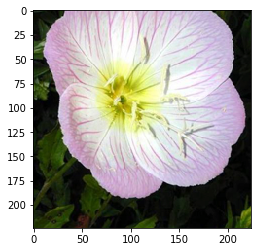

In [29]:
imshow(process_image("flowers/test/1/image_06743.jpg"))

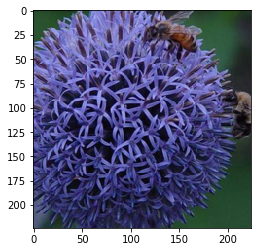

In [30]:
imshow(process_image("flowers/test/10/image_07090.jpg"));

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [33]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    # TODO: Implement the code to predict the class from an image file
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Load and preprocess the image.
    numpy_image = process_image(image_path)
    
    # Swith model to desire device.
    model.to(device)
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(numpy_image)
    torch_image = torch_image.unsqueeze(0)
    torch_image = torch_image.type(torch.FloatTensor)
    
    # Move input tensors to the GPU/CPU
    torch_image = torch_image.to(device) 

    # Find probabilities (results) by passing through the function (note the log softmax means that its on a log scale)
    # We also do torch.no_grad() so it doesn't try to keep track of calculating gradients and executes faster.
    with torch.no_grad():
        log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 results
    torch_top_probs, torch_top_labels = linear_probs.topk(top_k)
    
    # We want to return numpy arrays so it can be compatible with matplotlib.plt libraries.
    numpy_top_probs = torch_top_probs.cpu().numpy()[0]
    numpy_top_labels = torch_top_labels.cpu().numpy()[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    numpy_top_labels = [idx_to_class[lab] for lab in numpy_top_labels]
    
    return numpy_top_probs, numpy_top_labels#, top_flowers

We first predict with the original model:

In [34]:
im_path= "flowers/test/1/image_06743.jpg"

probs, classes = predict(im_path, model)
print(probs)
print(classes)

[9.9971014e-01 2.3972330e-04 3.8937342e-05 3.9713091e-06 2.9184907e-06]
['1', '83', '86', '76', '82']


Next, we predict with the model that was loaded:

In [35]:
probs, classes = predict(im_path, loaded_model)
print(probs)
print(classes)

[9.9971014e-01 2.3972330e-04 3.8937342e-05 3.9713091e-06 2.9184907e-06]
['1', '83', '86', '76', '82']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

We first define a sanity check function.

In [36]:
# TODO: Display an image along with the top 5 classes

def sanity_check(img_path, prediction_model):
    probs, classes = predict(img_path, prediction_model)
    #print(probs)
    #print(classes)

    names = [cat_to_name[i] for i in classes]
    #print(names)
    
    # Set up title
    flower_num = img_path.split('/')[2]
    title_ = cat_to_name[flower_num]

    fig = plt.figure(figsize=(5, 10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title(title_)
    img = process_image(img_path)
    imshow(img, ax1)

    ax2 = fig.add_subplot(2, 1, 2)
    ax2 = plt.yticks(range(5), names[::-1])
    ax2 = plt.barh(range(5), probs[::-1])

    plt.show()

To test our function, we are going to test with the first 10 images. 

In [37]:
im_path1 = "flowers/test/1/image_06743.jpg" # pink primrose, 1
im_path2 = "flowers/test/2/image_05100.jpg" # hard-leaved pocket orchid, 2 
im_path3 = "flowers/test/3/image_06634.jpg" # canterbury bells, 3
im_path4 = "flowers/test/4/image_05636.jpg" # sweet pea, 4
im_path5 = "flowers/test/5/image_05159.jpg" # english marigold, 5
im_path6 = "flowers/test/6/image_07173.jpg" # tiger lily, 6 
im_path7 = "flowers/test/7/image_07211.jpg" # moon orchid, 7
im_path8 = "flowers/test/8/image_03291.jpg" # bird of paradise, 8
im_path9 = "flowers/test/9/image_06410.jpg" # monkshood, 9
im_path10 = "flowers/test/10/image_07090.jpg" # globe thistle, 10

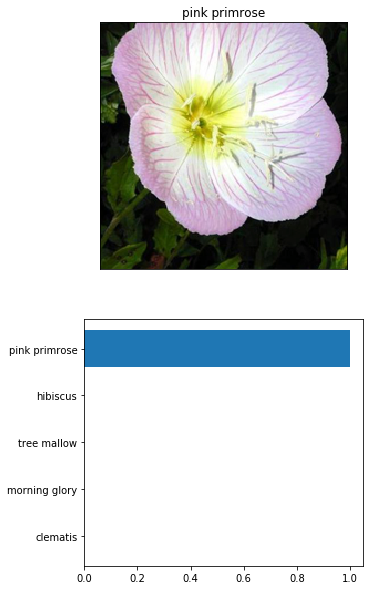

In [38]:
sanity_check(im_path1, loaded_model)

The flower pink primrose was correctly classified. In fact, the model had a probability of 1.0.

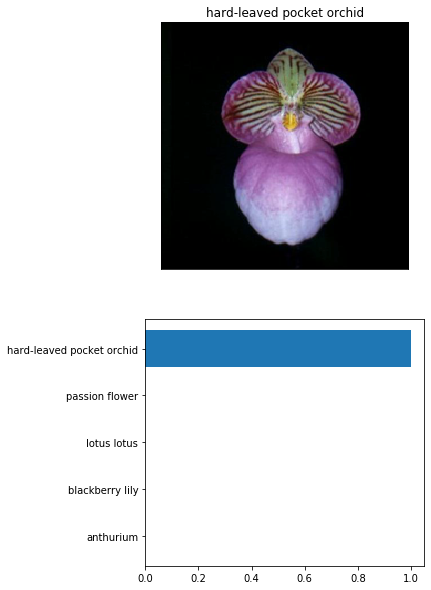

In [48]:
sanity_check(im_path2, loaded_model)

The flower hard-leaved pocket-orchid was correctly classified. In fact, the model had a probability of 1.0.

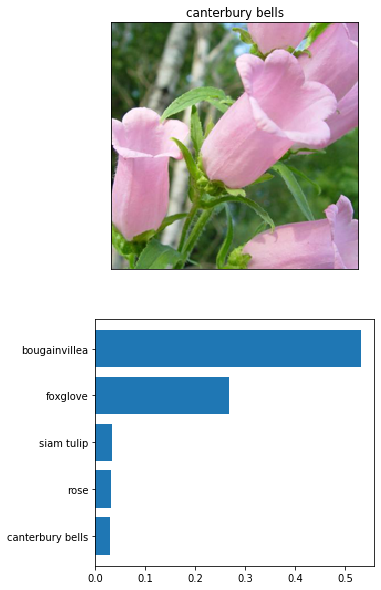

In [50]:
sanity_check(im_path3, loaded_model)

The flower canterbury bells was misclassified. Although canterbury bells was among it's top 5 guesses, the probability for the canterbury bells category was low.

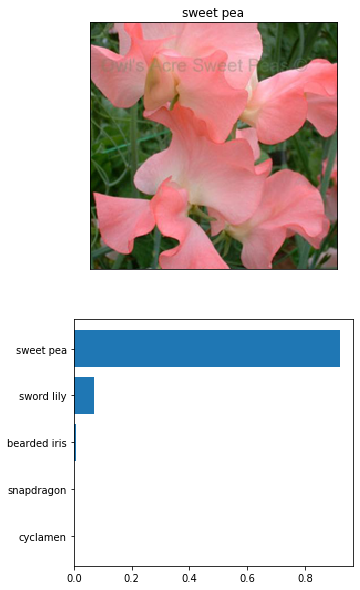

In [51]:
sanity_check(im_path4, loaded_model)

The flower sweet pea was classified correctly. The probabiity for the sweet pea category was about 0.9.

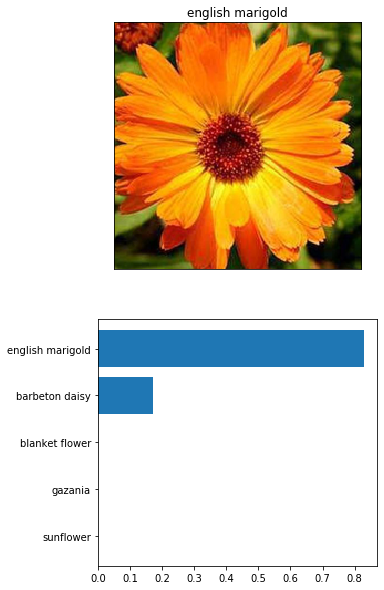

In [53]:
sanity_check(im_path5, loaded_model)

The flower english marigold was correctly classified. The probability for the english marigold category was about 0.8.

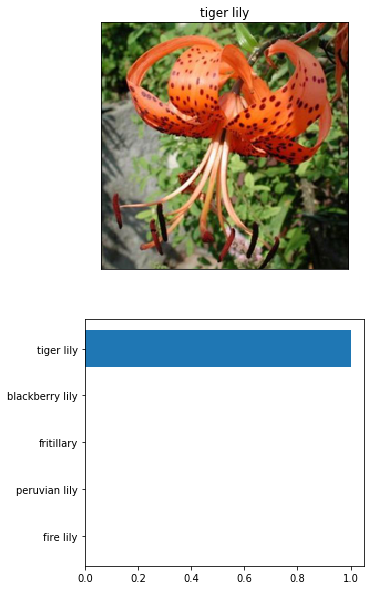

In [54]:
sanity_check(im_path6, loaded_model)

The flower tiger lily was correctly classified. The probability for the tiger lily category was 1.0.

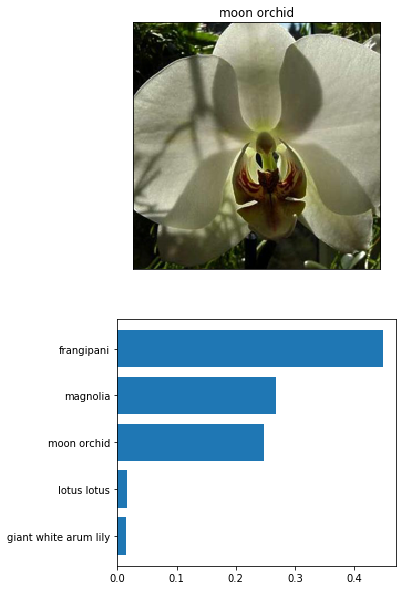

In [56]:
sanity_check(im_path7, loaded_model)

The flower moon orchid was misclassified. Although moon orchid was among it's top 5 guesses, the moon orchid category had a low 0.25 probability.

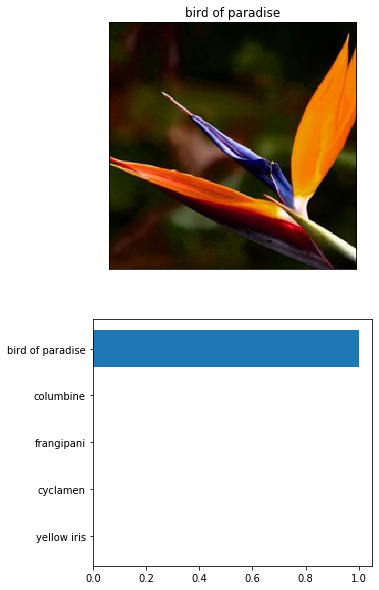

In [57]:
sanity_check(im_path8, loaded_model)

The flower bird of paradise was correctly classifie. The probability of the bird of paradise category was 1.0.

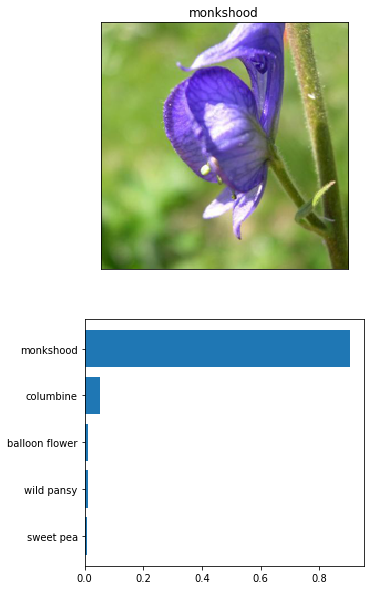

In [58]:
sanity_check(im_path9, loaded_model)

The flower monkshood was correctly classified. The probability of the monkshood category was about 0.85.

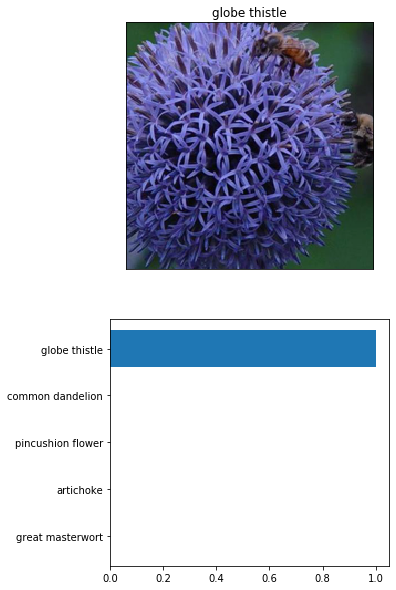

In [47]:
sanity_check(im_path10, loaded_model)

The flower globe thistle was correctly classified. The probability of the globe thistle was 1.0.

## Conclusion

A vss16 pretrained model was updated with a new classifier and the features frozen. This updated model was trained on flower images. During training, the model achieved an accuracy of 91.1% on the validation dataset. On the testing dataset, the model achieved an accuracy of 90.47%. A sanity check was done on the model by visually comparing the picture of the flower with the probabilities. On this sample set, the model got 8 out of 10 flower images correct.